In [ ]:
from google.colab import drive
import pathlib
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import xml.etree.ElementTree as ET
import sklearn.svm
import sklearn.cluster
import sklearn.linear_model
import sklearn.model_selection
import sklearn.tree
import lightgbm
import sklearn.metrics
import xgboost
from sklearn.decomposition import PCA
import matplotlib.pyplot
import numpy as np
import sklearn.ensemble

In [ ]:
seed = 17

# Function to calculate the F1-Score, TP, FP, FN, and TN

In [ ]:
def calculatefscore(expected,actual):
  TP=0
  FP=0
  FN=0
  TN=0
  for i in range(len(expected)):
    if actual[i]>=1 and expected[i]==1:
      TP=TP+1
    elif actual[i]==1 and expected[i]==0:
      FP=FP+1
    elif actual[i]==0 and expected[i]==1:
      FN=FN+1
    else:
      TN=TN+1
    

  fscore=2*TP/(2*TP+FP+FN)
  print("TP: "+ str(TP))
  print("FP: "+ str(FP))
  print("FN: "+ str(FN))
  print("TN: "+ str(TN))

# Data Prepaparation

permissionsMapFeat -  Has only permissions as a feature

permissionsMapFeat1 - Has permission, receiver as features

permissionsMapFeat2 - Has permission, receiver and activity as features

In [ ]:
malPermissionsMapFeat = pd.DataFrame(columns=['AppName','Permissions','isBenign'])
malPermissionsMapFeat1 = pd.DataFrame(columns=['AppName','Permissions','Receiver','isBenign'])
malPermissionsMapFeat2 = pd.DataFrame(columns=['AppName','Permissions','Receiver','Activity','isBenign'])


mal_dir = "/content/drive/MyDrive/extractedmanifestmalign"
for fileName in os.listdir(mal_dir):
  if fileName == '.DS_Store':
    continue
  try:
    androidManifest = ET.parse(mal_dir+'/'+fileName)
  except ET.ParseError:
    continue
  appName = fileName[:len(fileName)-20]
  permissionsList = []
  receiverList= []
  activityList=[]
  for permission in androidManifest.findall('uses-permission'):
    permissionsList.append(permission.attrib['{http://schemas.android.com/apk/res/android}name'])
  for receiver in androidManifest.findall('application/receiver'):
    receiverList.append(receiver.attrib['{http://schemas.android.com/apk/res/android}name'])
  for activity in androidManifest.findall('application/activity'):
    activityList.append(activity.attrib['{http://schemas.android.com/apk/res/android}name'])
  malPermissionsMapFeat.loc[len(malPermissionsMapFeat.index)] = [appName,permissionsList,0]
  malPermissionsMapFeat1.loc[len(malPermissionsMapFeat1.index)] = [appName,permissionsList,receiverList,0]
  malPermissionsMapFeat2.loc[len(malPermissionsMapFeat2.index)] = [appName,permissionsList,receiverList,activityList,0]

benPermissionsMapFeat = pd.DataFrame(columns=['AppName','Permissions','isBenign'])
benPermissionsMapFeat1 = pd.DataFrame(columns=['AppName','Permissions','Receiver','isBenign'])
benPermissionsMapFeat2 = pd.DataFrame(columns=['AppName','Permissions','Receiver','Activity','isBenign'])

ben_dir = "/content/drive/My Drive/extractedmanifestbenign"
for fileName in os.listdir(ben_dir):
  if fileName == '.DS_Store':
    continue
  try:
    androidManifest = ET.parse(ben_dir+'/'+fileName)
  except ET.ParseError:
    continue
  appName = fileName[:len(fileName)-20]
  permissionsList = []
  receiverList= []
  activityList=[]
  for permission in androidManifest.findall('uses-permission'):
    permissionsList.append(permission.attrib['{http://schemas.android.com/apk/res/android}name'])
  for receiver in androidManifest.findall('application/receiver'):
    receiverList.append(receiver.attrib['{http://schemas.android.com/apk/res/android}name'])
  for activity in androidManifest.findall('application/activity'):
    activityList.append(activity.attrib['{http://schemas.android.com/apk/res/android}name'])
  benPermissionsMapFeat.loc[len(benPermissionsMapFeat.index)] = [appName,permissionsList,1]
  benPermissionsMapFeat1.loc[len(benPermissionsMapFeat1.index)] = [appName,permissionsList,receiverList,1]
  benPermissionsMapFeat2.loc[len(benPermissionsMapFeat2.index)] = [appName,permissionsList,receiverList,activityList,1]

permissionsMapFeat=pd.concat([benPermissionsMapFeat,malPermissionsMapFeat],ignore_index=True)
permissionsMapFeat1=pd.concat([benPermissionsMapFeat1,malPermissionsMapFeat1],ignore_index=True)
permissionsMapFeat2=pd.concat([benPermissionsMapFeat2,malPermissionsMapFeat2],ignore_index=True)


multiLableBinarizer = MultiLabelBinarizer(sparse_output=True)
permissionsMapFeat = permissionsMapFeat.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat.pop('Permissions')),index=permissionsMapFeat.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat = permissionsMapFeat.drop('AppName', axis=1)
isBenFeat=permissionsMapFeat.isBenign
permissionsMapFeat = permissionsMapFeat.drop('isBenign', axis=1)
permissionsMapFeat=permissionsMapFeat.to_numpy()
isBenFeat=isBenFeat.to_numpy()

multiLableBinarizer = MultiLabelBinarizer(sparse_output=True)
permissionsMapFeat1 = permissionsMapFeat1.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat1.pop('Permissions')),index=permissionsMapFeat1.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat1 = permissionsMapFeat1.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat1.pop('Receiver')),index=permissionsMapFeat1.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat1 = permissionsMapFeat1.drop('AppName', axis=1)
isBenFeat1=permissionsMapFeat1.isBenign
permissionsMapFeat1 = permissionsMapFeat1.drop('isBenign', axis=1)
permissionsMapFeat1=permissionsMapFeat1.to_numpy()
isBenFeat1=isBenFeat1.to_numpy()
print(permissionsMapFeat2)
multiLableBinarizer = MultiLabelBinarizer(sparse_output=True)
permissionsMapFeat2 = permissionsMapFeat2.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat2.pop('Permissions')),index=permissionsMapFeat2.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat2 = permissionsMapFeat2.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat2.pop('Receiver')),index=permissionsMapFeat2.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat2 = permissionsMapFeat2.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat2.pop('Activity')),index=permissionsMapFeat2.index,columns=multiLableBinarizer.classes_))
print(permissionsMapFeat2)
permissionsMapFeat2 = permissionsMapFeat2.drop('AppName', axis=1)
isBenFeat2=permissionsMapFeat2.isBenign
permissionsMapFeat2 = permissionsMapFeat2.drop('isBenign', axis=1)
permissionsMapFeat2=permissionsMapFeat2.to_numpy()
isBenFeat2=isBenFeat2.to_numpy()


                              AppName  \
0                 com.nytimes.android   
1               com.mw.rouletteroyale   
2       com.musixmatch.android.lyrify   
3                com.oldwang1.darts-2   
4      com.nb.fingerprint.lock.free-7   
..                                ...   
967  6ecee7f961699cd7f0588af67fcb1874   
968  2769efb3895a32b89b525c4b57e0902f   
969  1ae249fc48db24293e4068c05be0e3ac   
970  0f3cba835e54a93153786dce86ee22bd   
971  5312cc7bedaefc5b7ed16b73e1fae113   

                                           Permissions  \
0    [com.nytimes.android.permission.C2D_MESSAGE, a...   
1    [android.permission.INTERNET, android.permissi...   
2    [com.musixmatch.android.lyrify.permission.C2D_...   
3    [android.permission.INTERNET, android.permissi...   
4    [android.permission.INTERNET, android.permissi...   
..                                                 ...   
967  [android.permission.INTERNET, android.permissi...   
968  [android.permission.INTERNET, android.

# Feature Extraction using PCA
Train test split - 80% Training 20% Testing

trainSet,testSet,trainRes,testRes - train test split of permissionMapFeat

trainSet1,testSet1,trainRes1,testRes1 - train test split of permissionMapFeat1

trainSet2,testSet2,trainRes2,testRes2 - train test split of permissionMapFeat2

In [12]:
trainSet,testSet,trainRes,testRes = sklearn.model_selection.train_test_split(permissionsMapFeat,isBenFeat, test_size=0.2, random_state=17)
trainSet1,testSet1,trainRes1,testRes1 = sklearn.model_selection.train_test_split(permissionsMapFeat1,isBenFeat1, test_size=0.2, random_state=17)
trainSet2,testSet2,trainRes2,testRes2 = sklearn.model_selection.train_test_split(permissionsMapFeat2,isBenFeat2, test_size=0.2, random_state=17)
n_components = 10

pca = PCA(n_components=n_components).fit(trainSet)
pca1 = PCA(n_components=n_components).fit(trainSet1)
pca2 = PCA(n_components=n_components).fit(trainSet2)




Text(0, 0.5, 'Fraction of total variance explained')

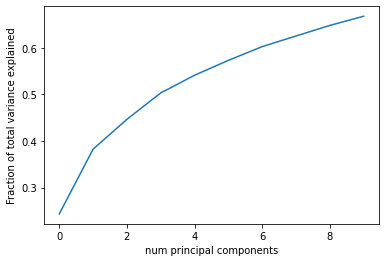

In [13]:
matplotlib.pyplot.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)
matplotlib.pyplot.xlabel('num principal components')
matplotlib.pyplot.ylabel('Fraction of total variance explained')



Text(0, 0.5, 'Fraction of total variance explained')

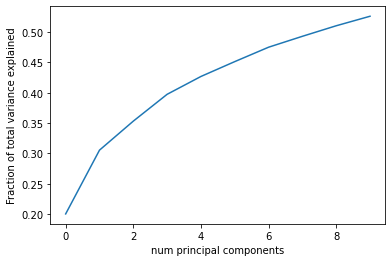

In [14]:
matplotlib.pyplot.plot(np.cumsum(pca1.explained_variance_ratio_))
np.cumsum(pca1.explained_variance_ratio_)
matplotlib.pyplot.xlabel('num principal components')
matplotlib.pyplot.ylabel('Fraction of total variance explained')



Text(0, 0.5, 'Fraction of total variance explained')

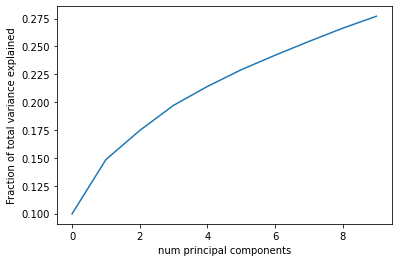

In [15]:
matplotlib.pyplot.plot(np.cumsum(pca2.explained_variance_ratio_))
np.cumsum(pca2.explained_variance_ratio_)
matplotlib.pyplot.xlabel('num principal components')
matplotlib.pyplot.ylabel('Fraction of total variance explained')

In [16]:
n_components = 3

In [17]:
pca = PCA(n_components=n_components).fit(trainSet)
pca1 = PCA(n_components=n_components).fit(trainSet1)
pca2 = PCA(n_components=n_components).fit(trainSet2)

In [18]:
X_train_pca = pca.transform(trainSet)
X_test_pca = pca.transform(testSet)

X_train_pca1 = pca1.transform(trainSet1)
X_test_pca1 = pca1.transform(testSet1)

X_train_pca2 = pca2.transform(trainSet2)
X_test_pca2 = pca2.transform(testSet2)

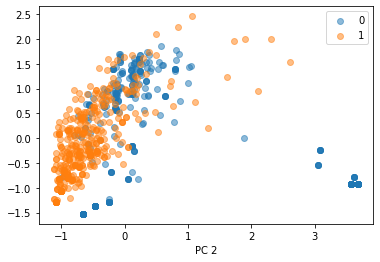

In [19]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_pca[trainRes==i][:,0], X_train_pca[trainRes==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

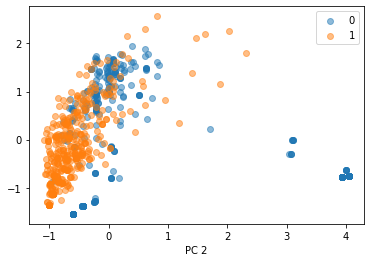

In [20]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_pca1[trainRes1==i][:,0], X_train_pca1[trainRes1==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

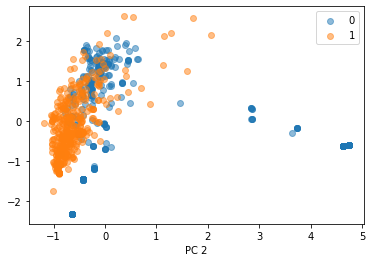

In [21]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_pca2[trainRes2==i][:,0], X_train_pca2[trainRes2==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

In [22]:
trainRes = trainRes.astype('int')
trainRes1 = trainRes1.astype('int')
trainRes2 = trainRes2.astype('int')

# SVM's for all three dataframes

**Cross Validation for SVM**

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svc = SVC(C=10000, kernel='rbf')
scores = cross_val_score(svc, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
svc1 = SVC(C=10000, kernel='rbf')
scores1 = cross_val_score(svc1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
svc2 = SVC(C=10000, kernel='rbf')
scores2 = cross_val_score(svc2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [24]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.874 +/- 0.017
Cross Validation accuracy: 0.884 +/- 0.015
Cross Validation accuracy: 0.901 +/- 0.017


In [26]:
svc.fit(X_train_pca, trainRes)
svc1 = SVC(C=10000, kernel='rbf')
svc1.fit(X_train_pca1, trainRes1)
svc2 = SVC(C=10000, kernel='rbf')
svc2.fit(X_train_pca2, trainRes2)

SVC(C=10000)

In [27]:
y_pred = svc.predict(X_test_pca)
y_pred1 = svc1.predict(X_test_pca1)
y_pred2 = svc2.predict(X_test_pca2)

In [28]:
testRes = testRes.astype('int')
testRes1 = testRes1.astype('int')
testRes2 = testRes2.astype('int')

In [29]:
from sklearn.metrics import classification_report

print(classification_report(testRes, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       105
           1       0.87      0.82      0.85        90

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195



In [30]:
print("SVM")
fscore=calculatefscore(testRes,y_pred)

SVM
TP: 74
FP: 11
FN: 16
TN: 94


In [31]:
print(classification_report(testRes1, y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       105
           1       0.84      0.87      0.85        90

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195



In [34]:
print("SVM PCA Feature-2")
fscore=calculatefscore(testRes1,y_pred1)

SVM PCA Feature-2
TP: 78
FP: 15
FN: 12
TN: 90


In [35]:
print(classification_report(testRes2, y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       105
           1       0.93      0.87      0.90        90

    accuracy                           0.91       195
   macro avg       0.91      0.90      0.91       195
weighted avg       0.91      0.91      0.91       195



In [36]:
print("SVM PCA Feature-3")
fscore=calculatefscore(testRes2,y_pred2)

SVM PCA Feature-3
TP: 78
FP: 6
FN: 12
TN: 99


# LightGBM Classifier

In [37]:
lgbmClassifier=lightgbm.LGBMClassifier()
scores = cross_val_score(lgbmClassifier, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
lgbmClassifier1=lightgbm.LGBMClassifier()
scores1 = cross_val_score(lgbmClassifier1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
lgbmClassifier2=lightgbm.LGBMClassifier()
scores2 = cross_val_score(lgbmClassifier2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [38]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.885 +/- 0.025
Cross Validation accuracy: 0.897 +/- 0.013
Cross Validation accuracy: 0.918 +/- 0.009


In [39]:
lgbmClassifier=lightgbm.LGBMClassifier()
lgbmClassifier.fit(X_train_pca, trainRes)
predLGBM = lgbmClassifier.predict(X_test_pca)

lgbmClassifier1=lightgbm.LGBMClassifier()
lgbmClassifier1.fit(X_train_pca1, trainRes1)
predLGBM1 = lgbmClassifier1.predict(X_test_pca1)

lgbmClassifier2=lightgbm.LGBMClassifier()
lgbmClassifier2.fit(X_train_pca2, trainRes2)
predLGBM2 = lgbmClassifier2.predict(X_test_pca2)


In [40]:
print(classification_report(testRes, predLGBM))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       105
           1       0.90      0.82      0.86        90

    accuracy                           0.88       195
   macro avg       0.88      0.87      0.88       195
weighted avg       0.88      0.88      0.88       195



In [41]:
print("LGBM")
fscore=calculatefscore(testRes,predLGBM)

LGBM
TP: 74
FP: 8
FN: 16
TN: 97


In [42]:
print(classification_report(testRes1, predLGBM1))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       105
           1       0.92      0.84      0.88        90

    accuracy                           0.89       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.89      0.89      0.89       195



In [43]:
print("LGBM PCA Feature-2")
fscore=calculatefscore(testRes1,predLGBM1)

LGBM PCA Feature-2
TP: 76
FP: 7
FN: 14
TN: 98


In [44]:
print(classification_report(testRes2, predLGBM2))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       105
           1       0.95      0.87      0.91        90

    accuracy                           0.92       195
   macro avg       0.92      0.91      0.92       195
weighted avg       0.92      0.92      0.92       195



In [45]:
print("LGBM PCA Feature-3")
fscore=calculatefscore(testRes2,predLGBM2)

LGBM PCA Feature-3
TP: 78
FP: 4
FN: 12
TN: 101


# Decision tree Classifier

In [46]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
scores = cross_val_score(decisionTreeClassifier, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
decisionTreeClassifier1=sklearn.tree.DecisionTreeClassifier()
scores1 = cross_val_score(decisionTreeClassifier1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
decisionTreeClassifier2=sklearn.tree.DecisionTreeClassifier()
scores2 = cross_val_score(decisionTreeClassifier2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [47]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.857 +/- 0.042
Cross Validation accuracy: 0.875 +/- 0.023
Cross Validation accuracy: 0.892 +/- 0.023


In [48]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train_pca, trainRes)
predDTC = decisionTreeClassifier.predict(X_test_pca)
print(classification_report(testRes, predDTC))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       105
           1       0.90      0.86      0.88        90

    accuracy                           0.89       195
   macro avg       0.89      0.88      0.89       195
weighted avg       0.89      0.89      0.89       195



In [49]:
print("Decision Tree PCA Feature-1")
fscore=calculatefscore(testRes,predDTC)

Decision Tree PCA Feature-1
TP: 77
FP: 9
FN: 13
TN: 96


In [50]:
decisionTreeClassifier1=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier1.fit(X_train_pca1, trainRes1)
predDTC1 = decisionTreeClassifier1.predict(X_test_pca1)
print(classification_report(testRes1, predDTC1))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90       105
           1       0.92      0.81      0.86        90

    accuracy                           0.88       195
   macro avg       0.89      0.88      0.88       195
weighted avg       0.89      0.88      0.88       195



In [51]:
print("Decision Tree PCA Feature-2")
fscore=calculatefscore(testRes1,predDTC1)

Decision Tree PCA Feature-2
TP: 73
FP: 6
FN: 17
TN: 99


In [52]:
decisionTreeClassifier2=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier2.fit(X_train_pca2, trainRes2)
predDTC2 = decisionTreeClassifier2.predict(X_test_pca2)
print(classification_report(testRes2, predDTC2))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       105
           1       0.89      0.90      0.90        90

    accuracy                           0.90       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.90      0.90      0.90       195



In [53]:
print("Decision Tree PCA Feature-3")
fscore=calculatefscore(testRes2,predDTC2)

Decision Tree PCA Feature-3
TP: 81
FP: 10
FN: 9
TN: 95


# XGBoost Classifier

In [54]:
xgBoostClassfier = xgboost.XGBClassifier()
scores = cross_val_score(xgBoostClassfier, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
xgBoostClassfier1 = xgboost.XGBClassifier()
scores1 = cross_val_score(xgBoostClassfier1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
xgBoostClassfier2 = xgboost.XGBClassifier()
scores2 = cross_val_score(xgBoostClassfier2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [55]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.884 +/- 0.029
Cross Validation accuracy: 0.907 +/- 0.026
Cross Validation accuracy: 0.907 +/- 0.016


In [56]:
xgBoostClassfier = xgboost.XGBClassifier()
xgBoostClassfier.fit(X_train_pca, trainRes)
predictionsXGBoost = xgBoostClassfier.predict(X_test_pca)
print(classification_report(testRes, predictionsXGBoost))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       105
           1       0.89      0.86      0.87        90

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195



In [57]:
print("XGBoost Classifier")
fscore=calculatefscore(testRes,predictionsXGBoost)

XGBoost Classifier
TP: 77
FP: 10
FN: 13
TN: 95


In [58]:
xgBoostClassfier1 = xgboost.XGBClassifier()
xgBoostClassfier1.fit(X_train_pca1, trainRes1)
predictionsXGBoost1 = xgBoostClassfier1.predict(X_test_pca1)
print(classification_report(testRes1, predictionsXGBoost1))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.89      0.82      0.86        90

    accuracy                           0.87       195
   macro avg       0.87      0.87      0.87       195
weighted avg       0.87      0.87      0.87       195



In [59]:
print("XGBoost Classifier PCA Feature-2")
fscore=calculatefscore(testRes1,predictionsXGBoost1)

XGBoost Classifier PCA Feature-2
TP: 74
FP: 9
FN: 16
TN: 96


In [60]:
xgBoostClassfier2 = xgboost.XGBClassifier()
xgBoostClassfier2.fit(X_train_pca2, trainRes2)
predictionsXGBoost2 = xgBoostClassfier2.predict(X_test_pca2)
print(classification_report(testRes2, predictionsXGBoost2))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       105
           1       0.92      0.86      0.89        90

    accuracy                           0.90       195
   macro avg       0.90      0.89      0.90       195
weighted avg       0.90      0.90      0.90       195



In [61]:
print("XGBoost Classifier PCA Feature-3")
fscore=calculatefscore(testRes2,predictionsXGBoost2)

XGBoost Classifier PCA Feature-3
TP: 77
FP: 7
FN: 13
TN: 98


# Random Forest Classifier

In [62]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
scores = cross_val_score(xgBoostClassfier, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
randomForestClassifier1 = sklearn.ensemble.RandomForestClassifier()
scores1 = cross_val_score(xgBoostClassfier1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
randomForestClassifier2 = sklearn.ensemble.RandomForestClassifier()
scores2 = cross_val_score(xgBoostClassfier2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [63]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.884 +/- 0.029
Cross Validation accuracy: 0.907 +/- 0.026
Cross Validation accuracy: 0.907 +/- 0.016


In [64]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier.fit(X_train_pca, trainRes)
predictionsRandomForest = randomForestClassifier.predict(X_test_pca)
print(classification_report(testRes, predictionsRandomForest))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       105
           1       0.91      0.88      0.89        90

    accuracy                           0.90       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.90      0.90      0.90       195



In [65]:
print("Random Forest")
fscore=calculatefscore(testRes,predictionsRandomForest)

Random Forest
TP: 79
FP: 8
FN: 11
TN: 97


In [66]:
randomForestClassifier1 = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier1.fit(X_train_pca1, trainRes1)
predictionsRandomForest1 = randomForestClassifier1.predict(X_test_pca1)
print(classification_report(testRes1, predictionsRandomForest1))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       105
           1       0.90      0.87      0.88        90

    accuracy                           0.89       195
   macro avg       0.89      0.89      0.89       195
weighted avg       0.89      0.89      0.89       195



In [67]:
print("Random Forest PCA Feature-2")
fscore=calculatefscore(testRes1,predictionsRandomForest1)

Random Forest PCA Feature-2
TP: 78
FP: 9
FN: 12
TN: 96


In [68]:
randomForestClassifier2 = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier2.fit(X_train_pca2, trainRes2)
predictionsRandomForest2 = randomForestClassifier2.predict(X_test_pca2)
print(classification_report(testRes2, predictionsRandomForest2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       105
           1       0.91      0.89      0.90        90

    accuracy                           0.91       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.91      0.91      0.91       195



In [69]:
print("Random Forest PCA Feature-3")
fscore=calculatefscore(testRes2,predictionsRandomForest2)

Random Forest PCA Feature-3
TP: 80
FP: 8
FN: 10
TN: 97


# Kernel PCA for Feature Extraction

In [70]:
from sklearn.decomposition import KernelPCA

n_components = 10

kpca = KernelPCA(n_components=n_components, kernel='rbf', fit_inverse_transform=True).fit(trainSet)
kpca1 = KernelPCA(n_components=n_components, kernel='rbf', fit_inverse_transform=True).fit(trainSet1)
kpca2 = KernelPCA(n_components=n_components, kernel='rbf', fit_inverse_transform=True).fit(trainSet2)

In [71]:
X_train_kpca = kpca.transform(trainSet)
X_test_kpca = kpca.transform(testSet)
X_train_kpca1 = kpca1.transform(trainSet1)
X_test_kpca1 = kpca1.transform(testSet1)
X_train_kpca2 = kpca2.transform(trainSet2)
X_test_kpca2 = kpca2.transform(testSet2)

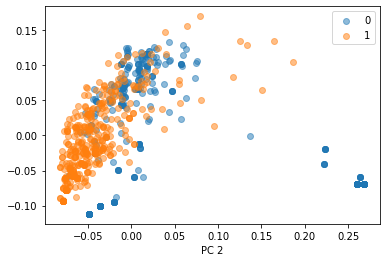

In [92]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_kpca[trainRes==i][:,0], X_train_kpca[trainRes==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

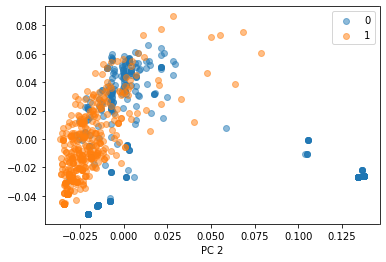

In [73]:
fig, ax = matplotlib.pyplot.subplots(1)
for i in range(2):
    ax.scatter(X_train_kpca1[trainRes1==i][:,0], X_train_kpca1[trainRes1==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

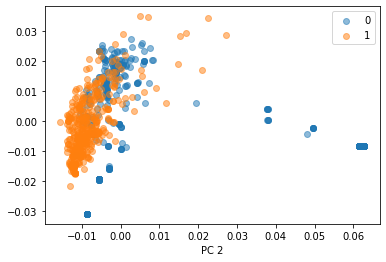

In [74]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_kpca2[trainRes2==i][:,0], X_train_kpca2[trainRes2==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

# SVM Classifier with Kernel PCA

In [94]:
svc = SVC(C=10000, kernel='rbf')
scores = cross_val_score(svc, X=X_train_kpca, y=trainRes, cv=5, n_jobs=1)
svc1 = SVC(C=10000, kernel='rbf')
scores1 = cross_val_score(svc1, X=X_train_kpca1, y=trainRes1, cv=5, n_jobs=1)
svc2 = SVC(C=10000, kernel='rbf')
scores2 = cross_val_score(svc2, X=X_train_kpca2, y=trainRes2, cv=5, n_jobs=1)

In [95]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.918 +/- 0.020
Cross Validation accuracy: 0.932 +/- 0.010
Cross Validation accuracy: 0.955 +/- 0.022


In [96]:
svc = SVC(C=10000, kernel='rbf')
svc.fit(X_train_kpca, trainRes)
y_pred_svm = svc.predict(X_test_kpca)
print(classification_report(testRes, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       105
           1       0.97      0.92      0.94        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [97]:
print("SVM")
fscore=calculatefscore(testRes,y_pred_svm)

SVM
TP: 83
FP: 3
FN: 7
TN: 102


In [79]:
svc1 = SVC(C=10000, kernel='rbf')
svc1.fit(X_train_kpca1, trainRes1)
y_pred_svm1 = svc1.predict(X_test_kpca1)
print(classification_report(testRes1, y_pred_svm1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       105
           1       0.94      0.94      0.94        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [80]:
print("SVM Kernel PCA Feature-2")
fscore=calculatefscore(testRes1,y_pred_svm1)

SVM Kernel PCA Feature-2
TP: 85
FP: 5
FN: 5
TN: 100


In [81]:
svc2 = SVC(C=10000, kernel='rbf')
svc2.fit(X_train_kpca2, trainRes2)
y_pred_svm2 = svc2.predict(X_test_kpca2)
print(classification_report(testRes2, y_pred_svm2))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       105
           1       0.97      0.93      0.95        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [82]:
print("SVM Kernel PCA Feature-3")
fscore=calculatefscore(testRes2,y_pred_svm2)

SVM Kernel PCA Feature-3
TP: 84
FP: 3
FN: 6
TN: 102


# LightGBM Classifier with Kernel PCA

In [83]:
lgbmClassifier=lightgbm.LGBMClassifier()
scores = cross_val_score(lgbmClassifier, X=X_train_kpca, y=trainRes, cv=5, n_jobs=1)
lgbmClassifier1=lightgbm.LGBMClassifier()
scores1 = cross_val_score(lgbmClassifier1, X=X_train_kpca1, y=trainRes1, cv=5, n_jobs=1)
lgbmClassifier2=lightgbm.LGBMClassifier()
scores2 = cross_val_score(lgbmClassifier2, X=X_train_kpca2, y=trainRes2, cv=5, n_jobs=1)

In [84]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.940 +/- 0.016
Cross Validation accuracy: 0.955 +/- 0.019
Cross Validation accuracy: 0.961 +/- 0.017


In [85]:
lgbmClassifier=lightgbm.LGBMClassifier()
lgbmClassifier.fit(X_train_kpca, trainRes)
predLGBMKpca = lgbmClassifier.predict(X_test_kpca)
print(classification_report(testRes, predLGBMKpca))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.95      0.96      0.95        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [86]:
print('LGBM')
fscore=calculatefscore(testRes,predLGBMKpca)

LGBM
TP: 86
FP: 5
FN: 4
TN: 100


In [87]:
lgbmClassifier1=lightgbm.LGBMClassifier()
lgbmClassifier1.fit(X_train_kpca1, trainRes1)
predLGBMKpca1 = lgbmClassifier1.predict(X_test_kpca1)
print(classification_report(testRes1, predLGBMKpca1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       105
           1       0.97      0.96      0.96        90

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [88]:
print('LGBM Kernel PCA Feature-2')
fscore=calculatefscore(testRes1,predLGBMKpca1)

LGBM Kernel PCA Feature-2
TP: 86
FP: 3
FN: 4
TN: 102


In [89]:
lgbmClassifier2=lightgbm.LGBMClassifier()
lgbmClassifier2.fit(X_train_kpca2, trainRes2)
predLGBMKpca2 = lgbmClassifier2.predict(X_test_kpca2)
print(classification_report(testRes2, predLGBMKpca2))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       105
           1       0.97      0.92      0.94        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [90]:
print('LGBM Kernel PCA Feature-3')
fscore=calculatefscore(testRes2,predLGBMKpca2)

LGBM Kernel PCA Feature-3
TP: 83
FP: 3
FN: 7
TN: 102


# Decision Tree Classifier with Kernel PCA

In [98]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
scores = cross_val_score(decisionTreeClassifier, X=X_train_kpca, y=trainRes, cv=5, n_jobs=1)
decisionTreeClassifier1=sklearn.tree.DecisionTreeClassifier()
scores1 = cross_val_score(decisionTreeClassifier1, X=X_train_kpca1, y=trainRes1, cv=5, n_jobs=1)
decisionTreeClassifier2=sklearn.tree.DecisionTreeClassifier()
scores2 = cross_val_score(decisionTreeClassifier2, X=X_train_kpca2, y=trainRes2, cv=5, n_jobs=1)

In [99]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.910 +/- 0.022
Cross Validation accuracy: 0.927 +/- 0.024
Cross Validation accuracy: 0.933 +/- 0.023


In [100]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train_kpca, trainRes)
predDTCKpca = decisionTreeClassifier.predict(X_test_kpca)
print(classification_report(testRes, predDTCKpca))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       105
           1       0.94      0.90      0.92        90

    accuracy                           0.93       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.93      0.93      0.93       195



In [101]:
print('Decision Tree Classifier')
fscore=calculatefscore(testRes,predDTCKpca)

Decision Tree Classifier
TP: 81
FP: 5
FN: 9
TN: 100


In [102]:
decisionTreeClassifier1=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier1.fit(X_train_kpca1, trainRes1)
predDTCKpca1 = decisionTreeClassifier1.predict(X_test_kpca1)
print(classification_report(testRes1, predDTCKpca1))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       105
           1       0.91      0.92      0.92        90

    accuracy                           0.92       195
   macro avg       0.92      0.92      0.92       195
weighted avg       0.92      0.92      0.92       195



In [103]:
print('Decision Tree Classifier Kernel PCA Feature-2')
fscore=calculatefscore(testRes1,predDTCKpca1)

Decision Tree Classifier Kernel PCA Feature-2
TP: 83
FP: 8
FN: 7
TN: 97


In [104]:
decisionTreeClassifier2=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier2.fit(X_train_kpca2, trainRes2)
predDTCKpca2 = decisionTreeClassifier2.predict(X_test_kpca2)
print(classification_report(testRes2, predDTCKpca2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       105
           1       0.99      0.92      0.95        90

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [105]:
print('Decision Tree Classifier Kernel PCA Feature-3')
fscore=calculatefscore(testRes2,predDTCKpca2)

Decision Tree Classifier Kernel PCA Feature-3
TP: 83
FP: 1
FN: 7
TN: 104


# XGBoost Classifier with Kernel PCA

In [106]:
xgBoostClassfier = xgboost.XGBClassifier()
scores = cross_val_score(xgBoostClassfier, X=X_train_kpca, y=trainRes, cv=5, n_jobs=1)
xgBoostClassfier1 = xgboost.XGBClassifier()
scores1 = cross_val_score(xgBoostClassfier1, X=X_train_kpca1, y=trainRes1, cv=5, n_jobs=1)
xgBoostClassfier2 = xgboost.XGBClassifier()
scores2 = cross_val_score(xgBoostClassfier2, X=X_train_kpca2, y=trainRes2, cv=5, n_jobs=1)

In [107]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.942 +/- 0.013
Cross Validation accuracy: 0.949 +/- 0.014
Cross Validation accuracy: 0.960 +/- 0.011


In [108]:
xgBoostClassfier = xgboost.XGBClassifier()
xgBoostClassfier.fit(X_train_kpca, trainRes)
predictionsXGBoostKpca = xgBoostClassfier.predict(X_test_kpca)
print(classification_report(testRes, predictionsXGBoostKpca))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       105
           1       0.93      0.94      0.94        90

    accuracy                           0.94       195
   macro avg       0.94      0.94      0.94       195
weighted avg       0.94      0.94      0.94       195



In [109]:
print('XGBoost')
fscore=calculatefscore(testRes,predictionsXGBoostKpca)

XGBoost
TP: 85
FP: 6
FN: 5
TN: 99


In [110]:
xgBoostClassfier1 = xgboost.XGBClassifier()
xgBoostClassfier1.fit(X_train_kpca1, trainRes1)
predictionsXGBoostKpca1 = xgBoostClassfier1.predict(X_test_kpca1)
print(classification_report(testRes1, predictionsXGBoostKpca1))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.95      0.96      0.95        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [111]:
print('XGBoost Kernel PCA Feature-2')
fscore=calculatefscore(testRes1,predictionsXGBoostKpca1)

XGBoost Kernel PCA Feature-2
TP: 86
FP: 5
FN: 4
TN: 100


In [112]:
xgBoostClassfier2 = xgboost.XGBClassifier()
xgBoostClassfier2.fit(X_train_kpca2, trainRes2)
predictionsXGBoostKpca2 = xgBoostClassfier2.predict(X_test_kpca2)
print(classification_report(testRes2, predictionsXGBoostKpca2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       105
           1       0.98      0.92      0.95        90

    accuracy                           0.95       195
   macro avg       0.96      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [113]:
print('XGBoost Kernel PCA Feature-3')
fscore=calculatefscore(testRes2,predictionsXGBoostKpca2)

XGBoost Kernel PCA Feature-3
TP: 83
FP: 2
FN: 7
TN: 103


# Random Forest Classifier with Kernel PCA

In [118]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
scores = cross_val_score(xgBoostClassfier, X=X_train_pca, y=trainRes, cv=5, n_jobs=1)
randomForestClassifier1 = sklearn.ensemble.RandomForestClassifier()
scores1 = cross_val_score(xgBoostClassfier1, X=X_train_pca1, y=trainRes1, cv=5, n_jobs=1)
randomForestClassifier2 = sklearn.ensemble.RandomForestClassifier()
scores2 = cross_val_score(xgBoostClassfier2, X=X_train_pca2, y=trainRes2, cv=5, n_jobs=1)

In [119]:
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy: 0.884 +/- 0.029
Cross Validation accuracy: 0.907 +/- 0.026
Cross Validation accuracy: 0.907 +/- 0.016


In [120]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier.fit(X_train_kpca, trainRes)
predictionsRandomForestKpca = randomForestClassifier.predict(X_test_kpca)
print(classification_report(testRes, predictionsRandomForestKpca))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       105
           1       0.94      0.94      0.94        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [121]:
print('Random Forest')
fscore=calculatefscore(testRes,predictionsRandomForestKpca)

Random Forest
TP: 85
FP: 5
FN: 5
TN: 100


In [122]:
randomForestClassifier1 = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier1.fit(X_train_kpca1, trainRes1)
predictionsRandomForestKpca1 = randomForestClassifier1.predict(X_test_kpca1)
print(classification_report(testRes1, predictionsRandomForestKpca1))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       105
           1       0.96      0.97      0.96        90

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [123]:
print('Random Forest Kernel PCA Feature-2')
fscore=calculatefscore(testRes1,predictionsRandomForestKpca1)

Random Forest Kernel PCA Feature-2
TP: 87
FP: 4
FN: 3
TN: 101


In [124]:
randomForestClassifier2 = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier2.fit(X_train_kpca2, trainRes2)
predictionsRandomForestKpca2 = randomForestClassifier2.predict(X_test_kpca2)
print(classification_report(testRes2, predictionsRandomForestKpca2))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       105
           1       0.98      0.94      0.96        90

    accuracy                           0.96       195
   macro avg       0.97      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [125]:
print('Random Forest Kernel PCA Feature-3')
fscore=calculatefscore(testRes2,predictionsRandomForestKpca2)

Random Forest Kernel PCA Feature-3
TP: 85
FP: 2
FN: 5
TN: 103
